In [0]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns

import os
import utils
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
import multiprocessing
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [0]:
import data, model, interpretation, utils, vis_utils, glm

In [0]:
test_data = np.load("test_data.npy")
test_label = np.load("test_label.npy")

test_data = np.reshape(test_data, (251, 1, 64, 64, 64))

# Initialize pretrained model

In [0]:
net = model.SingleTimestep3DCNN(in_num_ch=1, img_size=(64,64,64), inter_num_ch=16, fc_num_ch=16,
                                conv_act='relu', fc_act='tanh').to(torch.device('cpu'))

In [0]:
net.load_state_dict(torch.load('../ckpt/2020_5_18_16_42/epoch031.pth.tar')['model'])

<All keys matched successfully>

In [0]:
net.eval();

In [0]:
brain_map = vis_utils.load_nifti('aal.nii.gz')
brain_areas = np.unique(brain_map)[1:]  # omit background

area_masks = []
for area in tqdm_notebook(brain_areas):
    area_mask = np.zeros_like(brain_map)
    area_mask[brain_map == area] = 1
    area_mask = vis_utils.resize_image(area_mask, (64, 64, 64), interpolation=0)
    area_masks.append(area_mask)

area_names = ['Precentral_L', 'Precentral_R', 'Frontal_Sup_L', 'Frontal_Sup_R', 'Frontal_Sup_Orb_L', 'Frontal_Sup_Orb_R', 'Frontal_Mid_L', 'Frontal_Mid_R', 'Frontal_Mid_Orb_L', 'Frontal_Mid_Orb_R', 'Frontal_Inf_Oper_L', 'Frontal_Inf_Oper_R', 'Frontal_Inf_Tri_L', 'Frontal_Inf_Tri_R', 'Frontal_Inf_Orb_L', 'Frontal_Inf_Orb_R', 'Rolandic_Oper_L', 'Rolandic_Oper_R', 'Supp_Motor_Area_L', 'Supp_Motor_Area_R', 'Olfactory_L', 'Olfactory_R', 'Frontal_Sup_Medial_L', 'Frontal_Sup_Medial_R', 'Frontal_Med_Orb_L', 'Frontal_Med_Orb_R', 'Rectus_L', 'Rectus_R', 'Insula_L', 'Insula_R', 'Cingulum_Ant_L', 'Cingulum_Ant_R', 'Cingulum_Mid_L', 'Cingulum_Mid_R', 'Cingulum_Post_L', 'Cingulum_Post_R', 'Hippocampus_L', 'Hippocampus_R', 'ParaHippocampal_L', 'ParaHippocampal_R', 'Amygdala_L', 'Amygdala_R', 'Calcarine_L', 'Calcarine_R', 'Cuneus_L', 'Cuneus_R', 'Lingual_L', 'Lingual_R', 'Occipital_Sup_L', 'Occipital_Sup_R', 'Occipital_Mid_L', 'Occipital_Mid_R', 'Occipital_Inf_L', 'Occipital_Inf_R', 'Fusiform_L', 'Fusiform_R', 'Postcentral_L', 'Postcentral_R', 'Parietal_Sup_L', 'Parietal_Sup_R', 'Parietal_Inf_L', 'Parietal_Inf_R', 'SupraMarginal_L', 'SupraMarginal_R', 'Angular_L', 'Angular_R', 'Precuneus_L', 'Precuneus_R', 'Paracentral_Lobule_L', 'Paracentral_Lobule_R', 'Caudate_L', 'Caudate_R', 'Putamen_L', 'Putamen_R', 'Pallidum_L', 'Pallidum_R', 'Thalamus_L', 'Thalamus_R', 'Heschl_L', 'Heschl_R', 'Temporal_Sup_L', 'Temporal_Sup_R', 'Temporal_Pole_Sup_L', 'Temporal_Pole_Sup_R', 'Temporal_Mid_L', 'Temporal_Mid_R', 'Temporal_Pole_Mid_L', 'Temporal_Pole_Mid_R', 'Temporal_Inf_L', 'Temporal_Inf_R', 'Cerebelum_Crus1_L', 'Cerebelum_Crus1_R', 'Cerebelum_Crus2_L', 'Cerebelum_Crus2_R', 'Cerebelum_3_L', 'Cerebelum_3_R', 'Cerebelum_4_5_L', 'Cerebelum_4_5_R', 'Cerebelum_6_L', 'Cerebelum_6_R', 'Cerebelum_7b_L', 'Cerebelum_7b_R', 'Cerebelum_8_L', 'Cerebelum_8_R', 'Cerebelum_9_L', 'Cerebelum_9_R', 'Cerebelum_10_L', 'Cerebelum_10_R', 'Vermis_1_2', 'Vermis_3', 'Vermis_4_5', 'Vermis_6', 'Vermis_7', 'Vermis_8', 'Vermis_9', 'Vermis_10']

# Merge left and right areas.
merged_area_names = [name[:-2] for name in area_names[:108:2]] + area_names[108:]

In [0]:
def get_relevance_per_area(relevance_map, normalize=True):
    relevances = np.zeros(len(area_masks))
    print(relevances.shape)
    for i, area_mask in enumerate(area_masks):
        relevances[i] = np.sum(relevance_map * area_mask)
    if normalize:
        relevances /= relevances.sum()  # make all areas sum to 1

    # Merge left and right areas.
    merged_relevances = np.concatenate([relevances[:108].reshape(-1, 2).sum(1), relevances[108:]])

    return sorted(zip(merged_area_names, merged_relevances), key=lambda x: x[1], reverse=True)

In [0]:
brain_map.shape

(181, 217, 181)

# Sensitivity Analysis

- Loop through all test examples. 
- For each, record whether its label is NC or AD
- get relevance_map_backprop, and record whether it was correctly classified or not
- average relevance_map_backprop[0] at the end across the 4 categories (correct vs wrong classification, NC vs AD label)
- build dict, add up percentages of top 10 (for efficiency) areas -> then take top 5


In [0]:
#dict_A = {'a': 10, 'b': 5.4}
#dict_B = {'b': 1, 'c': 2}
#test_merge = merge_dicts(dict_A, dict_B)
#print(test_merge)

In [0]:
# shape: (1, 64, 64, 64)
# relevance maps; to be averaged after summing
map_AD_correct = np.zeros((1, 64, 64, 64))
map_AD_wrong = np.zeros((1, 64, 64, 64))
map_NC_correct = np.zeros((1, 64, 64, 64))
map_NC_wrong = np.zeros((1, 64, 64, 64))
map_AD = np.zeros((1, 64, 64, 64))
map_NC = np.zeros((1, 64, 64, 64))

# counts... to keep track and average later
count_AD_correct = 0
count_AD_wrong = 0
count_NC_correct = 0
count_NC_wrong = 0
count_AD = 0
count_NC = 0

# average of test images
img_AD_correct = np.zeros((64, 64, 64))
img_AD_wrong = np.zeros((64, 64, 64))
img_NC_correct = np.zeros((64, 64, 64))
img_NC_wrong = np.zeros((64, 64, 64))
img_AD = np.zeros((64, 64, 64))
img_NC = np.zeros((64, 64, 64))
img_global = np.zeros((64, 64, 64)) # average of entire dataset

# dict of top brain areas; to be summed
dict_AD_correct = {}
dict_AD_wrong = {}
dict_NC_correct = {}
dict_NC_wrong = {}
dict_AD = {}
dict_NC = {}

for i in range(251):
  #if i % 20 == 0:
  print("i: ", i)
  label = test_label[i]
  relevance_map_backprop, pred_label, _ = interpretation.sensitivity_analysis(net, test_data[i], cuda=False, verbose=True)
  case = -1
  if label == 1 and pred_label == 1:
    case = 1
    count_AD_correct += 1
    img_AD_correct += test_data[i][0]
    map_AD_correct += relevance_map_backprop
  elif label == 1 and pred_label == 0:
    case = 2
    count_AD_wrong += 1
    img_AD_wrong += test_data[i][0]
    map_AD_wrong += relevance_map_backprop
  elif label == 0 and pred_label == 0:
    case = 3
    count_NC_correct += 1
    img_NC_correct += test_data[i][0]
    map_NC_correct += relevance_map_backprop
  elif label == 0 and pred_label == 1:
    case = 4
    count_NC_wrong += 1
    img_NC_wrong += test_data[i][0]
    map_NC_wrong += relevance_map_backprop
  else:
    print("entered invalid case with (label, pred_label) = ", label, pred_label)
  
  areas_top_ten = get_relevance_per_area(relevance_map_backprop[0])[:10]
  dict_example = None
  if case == 1:
    dict_example = dict_AD_correct
  elif case == 2:
    dict_example = dict_AD_wrong
  elif case == 3:
    dict_example = dict_NC_correct
  elif case == 4:
    dict_example = dict_NC_wrong
  else: 
    print("invalid case ", case)
  for (area, pct) in areas_top_ten:
    if area in dict_example:
      dict_example[area] += pct
    else:
      dict_example[area] = pct



i:  0
tensor([[-6.2830]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9981356577482074
one hot output:  tensor([[[1.],
         [0.]]])
(116,)
i:  1
tensor([[-5.2428]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.994742373470217
one hot output:  tensor([[[1.],
         [0.]]])
(116,)
i:  2
tensor([[-5.6378]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9964518633205444
one hot output:  tensor([[[1.],
         [0.]]])
(116,)
i:  3
tensor([[5.5752]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 1 with probability 0.9962234497070312
one hot output:  tensor([[[0.],
         [1.]]])
(116,)
i:  4
tensor([[6.3118]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 1 with probability 0.9981884360313416
one hot output:  tensor([[[0.],
         [1.]]])
(116,)
i:  5
tensor([[6.1840]], grad_fn=<AddmmBackward>) torch.Size([1

(116,)
i:  44
tensor([[-6.2622]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9980966681614518
one hot output:  tensor([[[1.],
         [0.]]])
(116,)
i:  45
tensor([[-6.3881]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9983213740633801
one hot output:  tensor([[[1.],
         [0.]]])
(116,)
i:  46
tensor([[-6.3722]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9982945543015376
one hot output:  tensor([[[1.],
         [0.]]])
(116,)
i:  47
tensor([[-6.3560]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9982667082222179
one hot output:  tensor([[[1.],
         [0.]]])
(116,)
i:  48
tensor([[-6.3329]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9982263350393623
one hot output:  tensor([[[1.],
         [0.]]])
(116,)
i:  49
tensor([[-6.3842]], grad_fn=<AddmmBackwar

(116,)
i:  88
tensor([[5.4006]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 1 with probability 0.9955064058303833
one hot output:  tensor([[[0.],
         [1.]]])
(116,)
i:  89
tensor([[5.8918]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 1 with probability 0.9972456693649292
one hot output:  tensor([[[0.],
         [1.]]])
(116,)
i:  90
tensor([[2.7935]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 1 with probability 0.942322850227356
one hot output:  tensor([[[0.],
         [1.]]])
(116,)
i:  91
tensor([[1.7586]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 1 with probability 0.8530322313308716
one hot output:  tensor([[[0.],
         [1.]]])
(116,)
i:  92
tensor([[2.4333]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 1 with probability 0.9193318486213684
one hot output:  tensor([[[0.],
         [1.]]])
(116,)
i:  93
tensor([[5.3471]], grad_fn=<AddmmBackward>) tor

(116,)
i:  132
tensor([[-6.3775]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9983035598415881
one hot output:  tensor([[[1.],
         [0.]]])
(116,)
i:  133
tensor([[3.3467]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 1 with probability 0.9659955501556396
one hot output:  tensor([[[0.],
         [1.]]])
(116,)
i:  134
tensor([[5.8235]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 1 with probability 0.9970515966415405
one hot output:  tensor([[[0.],
         [1.]]])
(116,)
i:  135
tensor([[5.5013]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 1 with probability 0.9959350824356079
one hot output:  tensor([[[0.],
         [1.]]])
(116,)
i:  136
tensor([[5.9569]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 1 with probability 0.9974186420440674
one hot output:  tensor([[[0.],
         [1.]]])
(116,)
i:  137
tensor([[6.0031]], grad_fn=<AddmmBackwa

(116,)
i:  176
tensor([[-6.0088]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9975489396601915
one hot output:  tensor([[[1.],
         [0.]]])
(116,)
i:  177
tensor([[-3.7568]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9771744720637798
one hot output:  tensor([[[1.],
         [0.]]])
(116,)
i:  178
tensor([[-6.3187]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9982010213425383
one hot output:  tensor([[[1.],
         [0.]]])
(116,)
i:  179
tensor([[-0.9474]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.7205913662910461
one hot output:  tensor([[[1.],
         [0.]]])
(116,)
i:  180
tensor([[3.1591]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 1 with probability 0.9592643976211548
one hot output:  tensor([[[0.],
         [1.]]])
(116,)
i:  181
tensor([[5.1106]], grad_fn=<AddmmBac

(116,)
i:  220
tensor([[6.0819]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 1 with probability 0.9977214932441711
one hot output:  tensor([[[0.],
         [1.]]])
(116,)
i:  221
tensor([[-6.3781]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9983045931439847
one hot output:  tensor([[[1.],
         [0.]]])
(116,)
i:  222
tensor([[-6.2252]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.998024944216013
one hot output:  tensor([[[1.],
         [0.]]])
(116,)
i:  223
tensor([[6.0012]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 1 with probability 0.9975302815437317
one hot output:  tensor([[[0.],
         [1.]]])
(116,)
i:  224
tensor([[-1.0887]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.7481370866298676
one hot output:  tensor([[[1.],
         [0.]]])
(116,)
i:  225
tensor([[-6.3121]], grad_fn=<AddmmBack

In [0]:
# some post-processing
map_AD = map_AD_correct + map_AD_wrong
map_NC = map_NC_correct + map_NC_wrong
count_AD = count_AD_correct + count_AD_wrong
count_NC = count_NC_correct + count_NC_wrong
img_AD = img_AD_correct + img_AD_wrong 
img_NC = img_NC_correct + img_NC_wrong
img_global = img_AD + img_NC

dict_AD = data.merge_dicts(dict_AD_correct, dict_AD_wrong)
dict_NC = data.merge_dicts(dict_NC_correct, dict_NC_wrong)

In [0]:
print(count_AD_correct, count_AD_wrong, count_NC_correct, count_NC_wrong)

57 32 149 13


In [0]:
# we need to average the maps across the number of examples that were summed up
map_AD_correct /= count_AD_correct
map_AD_wrong /= count_AD_wrong
map_NC_correct /= count_NC_correct
map_NC_wrong /= count_NC_wrong
map_AD /= count_AD
map_NC /= count_NC

# also average the images
img_AD_correct /= count_AD_correct
img_AD_wrong /= count_AD_wrong
img_NC_correct /= count_NC_correct
img_NC_wrong /= count_NC_wrong
img_AD /= count_AD
img_NC /= count_NC
img_global /= 251

-0.7620625321536576 1.9976536631661175 2.4692311611575374e-07 0.003333959016368086
-0.7620625321536576 1.9976536631661175 2.1960833990371242e-07 0.006435240801810465
-0.7620625321536576 1.9976536631661175 6.409916602041302e-08 0.001898909069749164
-0.7620625321536576 1.9976536631661175 2.3722645454864295e-07 0.009933414743653194
-0.7620625321536576 1.9976536631661175 3.0224290583341143e-07 0.003991627657199115
-0.7620625321536576 1.9976536631661175 8.416797555004248e-08 0.002378225567695678


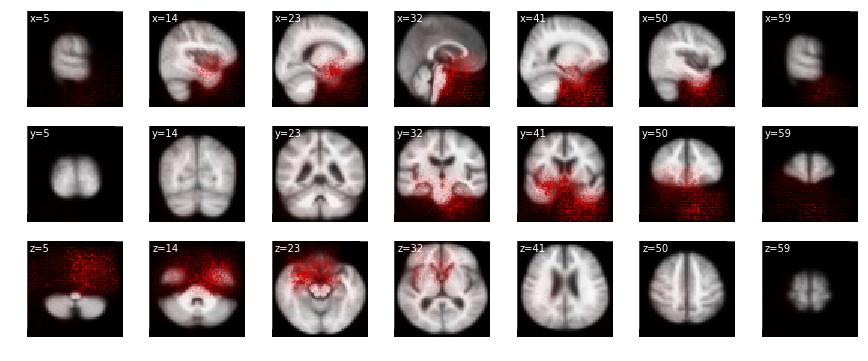

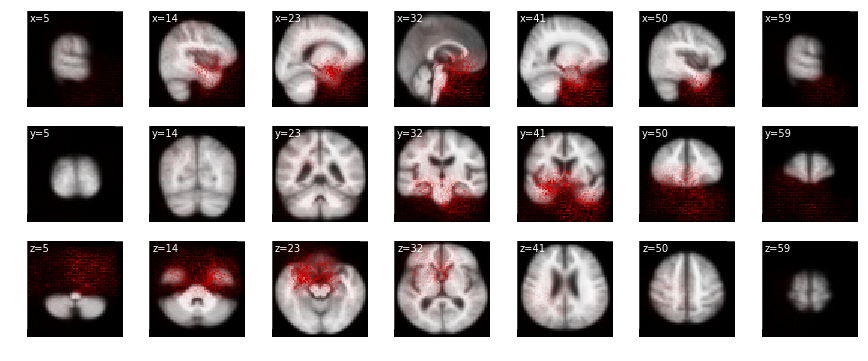

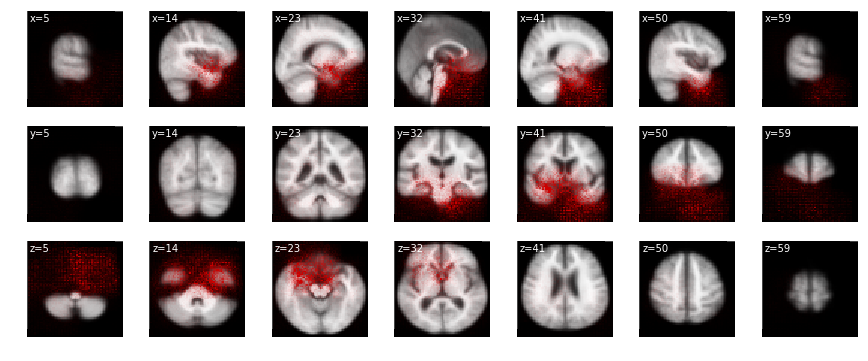

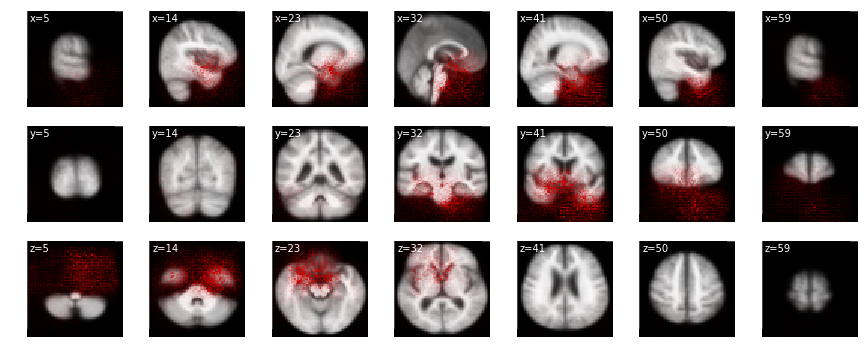

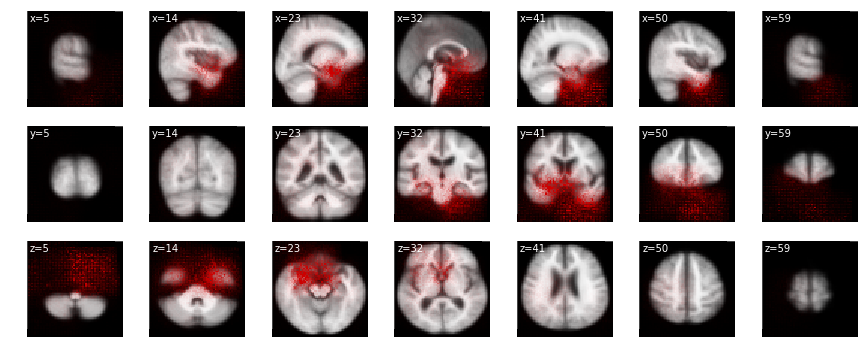

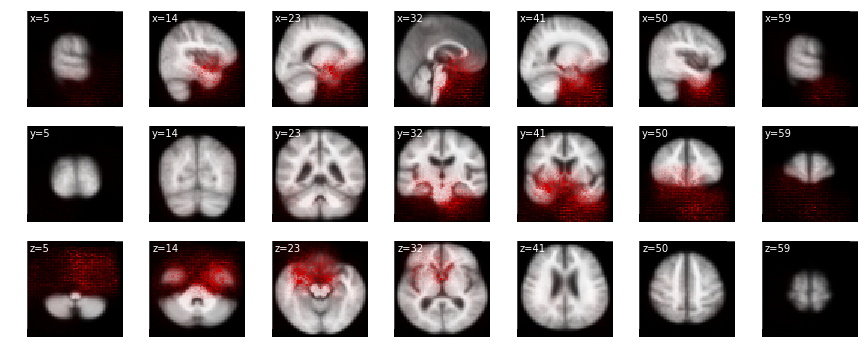

In [0]:
# now we plot the averaged maps, for each category!
# probably want to do some quantitative results with the vmin, vmax, overlay min/max
vmin_AD_correct, vmax_AD_correct, overlay_vmin_AD_correct, overlay_vmax_AD_correct = vis_utils.plot_slices(img_global, num_slices = 7, overlay=map_AD_correct[0], 
                  overlay_vmax=np.percentile(map_AD_correct, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

vmin_AD_wrong, vmax_AD_wrong, overlay_vmin_AD_wrong, overlay_vmax_AD_wrong = vis_utils.plot_slices(img_global, num_slices = 7, overlay=map_AD_wrong[0], 
                  overlay_vmax=np.percentile(map_AD_wrong, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

vmin_NC_correct, vmax_NC_correct, overlay_vmin_NC_correct, overlay_vmax_NC_correct = vis_utils.plot_slices(img_global, num_slices = 7, overlay=map_NC_correct[0], 
                  overlay_vmax=np.percentile(map_NC_correct, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

vmin_NC_wrong, vmax_NC_wrong, overlay_vmin_NC_wrong, overlay_vmax_NC_wrong = vis_utils.plot_slices(img_global, num_slices = 7, overlay=map_NC_wrong[0], 
                  overlay_vmax=np.percentile(map_NC_wrong, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

vmin_AD, vmax_AD, overlay_vmin_AD, overlay_vmax_AD = vis_utils.plot_slices(img_global, num_slices = 7, overlay=map_AD[0], 
                  overlay_vmax=np.percentile(map_AD, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

vmin_NC, vmax_NC, overlay_vmin_NC, overlay_vmax_NC = vis_utils.plot_slices(img_global, num_slices = 7, overlay=map_NC[0], 
                  overlay_vmax=np.percentile(map_NC, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)


In [0]:
# get relevance areas across each category
from operator import itemgetter

res_AD_correct = dict(sorted(dict_AD_correct.items(), key = itemgetter(1), reverse = True)[:5])
res_AD_wrong = dict(sorted(dict_AD_wrong.items(), key = itemgetter(1), reverse = True)[:5])
res_NC_correct = dict(sorted(dict_NC_correct.items(), key = itemgetter(1), reverse = True)[:5])
res_NC_wrong = dict(sorted(dict_NC_wrong.items(), key = itemgetter(1), reverse = True)[:5])
res_AD = dict(sorted(dict_AD.items(), key = itemgetter(1), reverse = True)[:5])
res_NC = dict(sorted(dict_NC.items(), key = itemgetter(1), reverse = True)[:5])

print(res_AD_correct)
print(res_AD_wrong)
print(res_NC_correct)
print(res_NC_wrong)
print(res_AD)
print(res_NC)


{'Temporal_Inf': 4.254390526536008, 'Frontal_Inf_Orb': 3.3366467560405795, 'Temporal_Mid': 2.7627877799797673, 'Temporal_Pole_Mid': 2.6341470253110164, 'Insula': 2.5566078734039115}
{'Temporal_Inf': 2.0128953899864386, 'Frontal_Inf_Orb': 1.7858318370508421, 'Insula': 1.5794147199537805, 'Temporal_Mid': 1.3858291071631743, 'Putamen': 1.2201160277864644}
{'Temporal_Inf': 8.888651354956417, 'Frontal_Inf_Orb': 7.846986335416999, 'Insula': 7.416941950331142, 'Temporal_Mid': 6.743456727764159, 'Frontal_Inf_Tri': 5.72849355992265}
{'Temporal_Inf': 0.9111956899747429, 'Frontal_Inf_Orb': 0.7745159513202629, 'Insula': 0.664944610366657, 'Temporal_Mid': 0.6343623733414433, 'Temporal_Pole_Sup': 0.564293514290062}
{'Temporal_Inf': 6.267285916522447, 'Frontal_Inf_Orb': 5.122478593091421, 'Temporal_Mid': 4.148616887142942, 'Insula': 4.136022593357692, 'Temporal_Pole_Mid': 3.634616750470233}
{'Temporal_Inf': 9.79984704493116, 'Frontal_Inf_Orb': 8.621502286737263, 'Insula': 8.0818865606978, 'Temporal_M

# Guided backprop

In [0]:
# shape: (1, 64, 64, 64)
# relevance maps; to be averaged after summing
map_AD_correct = np.zeros((1, 64, 64, 64))
map_AD_wrong = np.zeros((1, 64, 64, 64))
map_NC_correct = np.zeros((1, 64, 64, 64))
map_NC_wrong = np.zeros((1, 64, 64, 64))
map_AD = np.zeros((1, 64, 64, 64))
map_NC = np.zeros((1, 64, 64, 64))

# counts... to keep track and average later
count_AD_correct = 0
count_AD_wrong = 0
count_NC_correct = 0
count_NC_wrong = 0
count_AD = 0
count_NC = 0

# average of test images
img_AD_correct = np.zeros((64, 64, 64))
img_AD_wrong = np.zeros((64, 64, 64))
img_NC_correct = np.zeros((64, 64, 64))
img_NC_wrong = np.zeros((64, 64, 64))
img_AD = np.zeros((64, 64, 64))
img_NC = np.zeros((64, 64, 64))
img_global = np.zeros((64, 64, 64)) # average of entire dataset

# dict of top brain areas; to be summed
dict_AD_correct = {}
dict_AD_wrong = {}
dict_NC_correct = {}
dict_NC_wrong = {}
dict_AD = {}
dict_NC = {}

for i in range(251):
  #if i % 20 == 0:
  print("i: ", i)
  label = test_label[i]
  relevance_map_backprop, pred_label, _ = interpretation.guided_backprop(net, test_data[i], cuda=False, verbose=True)
  case = -1
  if label == 1 and pred_label == 1:
    case = 1
    count_AD_correct += 1
    img_AD_correct += test_data[i][0]
    map_AD_correct += relevance_map_backprop
  elif label == 1 and pred_label == 0:
    case = 2
    count_AD_wrong += 1
    img_AD_wrong += test_data[i][0]
    map_AD_wrong += relevance_map_backprop
  elif label == 0 and pred_label == 0:
    case = 3
    count_NC_correct += 1
    img_NC_correct += test_data[i][0]
    map_NC_correct += relevance_map_backprop
  elif label == 0 and pred_label == 1:
    case = 4
    count_NC_wrong += 1
    img_NC_wrong += test_data[i][0]
    map_NC_wrong += relevance_map_backprop
  else:
    print("entered invalid case with (label, pred_label) = ", label, pred_label)
  
  areas_top_ten = get_relevance_per_area(relevance_map_backprop[0])[:10]
  dict_example = None
  if case == 1:
    dict_example = dict_AD_correct
  elif case == 2:
    dict_example = dict_AD_wrong
  elif case == 3:
    dict_example = dict_NC_correct
  elif case == 4:
    dict_example = dict_NC_wrong
  else: 
    print("invalid case ", case)
  for (area, pct) in areas_top_ten:
    if area in dict_example:
      dict_example[area] += pct
    else:
      dict_example[area] = pct

In [0]:
# some post-processing
map_AD = map_AD_correct + map_AD_wrong
map_NC = map_NC_correct + map_NC_wrong
count_AD = count_AD_correct + count_AD_wrong
count_NC = count_NC_correct + count_NC_wrong
img_AD = img_AD_correct + img_AD_wrong 
img_NC = img_NC_correct + img_NC_wrong
img_global = img_AD + img_NC

dict_AD = data.merge_dicts(dict_AD_correct, dict_AD_wrong)
dict_NC = data.merge_dicts(dict_NC_correct, dict_NC_wrong)

In [0]:
print(count_AD_correct, count_AD_wrong, count_NC_correct, count_NC_wrong)

In [0]:
# we need to average the maps across the number of examples that were summed up
map_AD_correct /= count_AD_correct
map_AD_wrong /= count_AD_wrong
map_NC_correct /= count_NC_correct
map_NC_wrong /= count_NC_wrong
map_AD /= count_AD
map_NC /= count_NC

# also average the images
img_AD_correct /= count_AD_correct
img_AD_wrong /= count_AD_wrong
img_NC_correct /= count_NC_correct
img_NC_wrong /= count_NC_wrong
img_AD /= count_AD
img_NC /= count_NC
img_global /= 251

In [0]:
# now we plot the averaged maps, for each category!
# probably want to do some quantitative results with the vmin, vmax, overlay min/max
vmin_AD_correct, vmax_AD_correct, overlay_vmin_AD_correct, overlay_vmax_AD_correct = vis_utils.plot_slices(img_global, num_slices = 7, overlay=map_AD_correct[0], 
                  overlay_vmax=np.percentile(map_AD_correct, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

vmin_AD_wrong, vmax_AD_wrong, overlay_vmin_AD_wrong, overlay_vmax_AD_wrong = vis_utils.plot_slices(img_global, num_slices = 7, overlay=map_AD_wrong[0], 
                  overlay_vmax=np.percentile(map_AD_wrong, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

vmin_NC_correct, vmax_NC_correct, overlay_vmin_NC_correct, overlay_vmax_NC_correct = vis_utils.plot_slices(img_global, num_slices = 7, overlay=map_NC_correct[0], 
                  overlay_vmax=np.percentile(map_NC_correct, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

vmin_NC_wrong, vmax_NC_wrong, overlay_vmin_NC_wrong, overlay_vmax_NC_wrong = vis_utils.plot_slices(img_global, num_slices = 7, overlay=map_NC_wrong[0], 
                  overlay_vmax=np.percentile(map_NC_wrong, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

vmin_AD, vmax_AD, overlay_vmin_AD, overlay_vmax_AD = vis_utils.plot_slices(img_global, num_slices = 7, overlay=map_AD[0], 
                  overlay_vmax=np.percentile(map_AD, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

vmin_NC, vmax_NC, overlay_vmin_NC, overlay_vmax_NC = vis_utils.plot_slices(img_global, num_slices = 7, overlay=map_NC[0], 
                  overlay_vmax=np.percentile(map_NC, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

In [0]:
# get relevance areas across each category
from operator import itemgetter

res_AD_correct = dict(sorted(dict_AD_correct.items(), key = itemgetter(1), reverse = True)[:5])
res_AD_wrong = dict(sorted(dict_AD_wrong.items(), key = itemgetter(1), reverse = True)[:5])
res_NC_correct = dict(sorted(dict_NC_correct.items(), key = itemgetter(1), reverse = True)[:5])
res_NC_wrong = dict(sorted(dict_NC_wrong.items(), key = itemgetter(1), reverse = True)[:5])
res_AD = dict(sorted(dict_AD.items(), key = itemgetter(1), reverse = True)[:5])
res_NC = dict(sorted(dict_NC.items(), key = itemgetter(1), reverse = True)[:5])

print(res_AD_correct)
print(res_AD_wrong)
print(res_NC_correct)
print(res_NC_wrong)
print(res_AD)
print(res_NC)

# Occlusion



In [0]:
# shape: (1, 64, 64, 64)
# relevance maps; to be averaged after summing
map_AD_correct = np.zeros((1, 64, 64, 64))
map_AD_wrong = np.zeros((1, 64, 64, 64))
map_NC_correct = np.zeros((1, 64, 64, 64))
map_NC_wrong = np.zeros((1, 64, 64, 64))
map_AD = np.zeros((1, 64, 64, 64))
map_NC = np.zeros((1, 64, 64, 64))

# counts... to keep track and average later
count_AD_correct = 0
count_AD_wrong = 0
count_NC_correct = 0
count_NC_wrong = 0
count_AD = 0
count_NC = 0

# average of test images
img_AD_correct = np.zeros((64, 64, 64))
img_AD_wrong = np.zeros((64, 64, 64))
img_NC_correct = np.zeros((64, 64, 64))
img_NC_wrong = np.zeros((64, 64, 64))
img_AD = np.zeros((64, 64, 64))
img_NC = np.zeros((64, 64, 64))
img_global = np.zeros((64, 64, 64)) # average of entire dataset

# dict of top brain areas; to be summed
dict_AD_correct = {}
dict_AD_wrong = {}
dict_NC_correct = {}
dict_NC_wrong = {}
dict_AD = {}
dict_NC = {}

for i in range(251):
  #if i % 20 == 0:
  print("i: ", i)
  label = test_label[i]
  relevance_map_backprop, pred_label, _ = interpretation.sensitivity_analysis(net, test_data[i], size=8, stride=8, occlusion_value=0, cuda=False, resize=True, verbose=True)
  case = -1
  if label == 1 and pred_label == 1:
    case = 1
    count_AD_correct += 1
    img_AD_correct += test_data[i][0]
    map_AD_correct += relevance_map_backprop
  elif label == 1 and pred_label == 0:
    case = 2
    count_AD_wrong += 1
    img_AD_wrong += test_data[i][0]
    map_AD_wrong += relevance_map_backprop
  elif label == 0 and pred_label == 0:
    case = 3
    count_NC_correct += 1
    img_NC_correct += test_data[i][0]
    map_NC_correct += relevance_map_backprop
  elif label == 0 and pred_label == 1:
    case = 4
    count_NC_wrong += 1
    img_NC_wrong += test_data[i][0]
    map_NC_wrong += relevance_map_backprop
  else:
    print("entered invalid case with (label, pred_label) = ", label, pred_label)
  
  areas_top_ten = get_relevance_per_area(relevance_map_backprop[0])[:10]
  dict_example = None
  if case == 1:
    dict_example = dict_AD_correct
  elif case == 2:
    dict_example = dict_AD_wrong
  elif case == 3:
    dict_example = dict_NC_correct
  elif case == 4:
    dict_example = dict_NC_wrong
  else: 
    print("invalid case ", case)
  for (area, pct) in areas_top_ten:
    if area in dict_example:
      dict_example[area] += pct
    else:
      dict_example[area] = pct

In [0]:
# some post-processing
map_AD = map_AD_correct + map_AD_wrong
map_NC = map_NC_correct + map_NC_wrong
count_AD = count_AD_correct + count_AD_wrong
count_NC = count_NC_correct + count_NC_wrong
img_AD = img_AD_correct + img_AD_wrong 
img_NC = img_NC_correct + img_NC_wrong
img_global = img_AD + img_NC

dict_AD = data.merge_dicts(dict_AD_correct, dict_AD_wrong)
dict_NC = data.merge_dicts(dict_NC_correct, dict_NC_wrong)

In [0]:
print(count_AD_correct, count_AD_wrong, count_NC_correct, count_NC_wrong)

In [0]:
# we need to average the maps across the number of examples that were summed up
map_AD_correct /= count_AD_correct
map_AD_wrong /= count_AD_wrong
map_NC_correct /= count_NC_correct
map_NC_wrong /= count_NC_wrong
map_AD /= count_AD
map_NC /= count_NC

# also average the images
img_AD_correct /= count_AD_correct
img_AD_wrong /= count_AD_wrong
img_NC_correct /= count_NC_correct
img_NC_wrong /= count_NC_wrong
img_AD /= count_AD
img_NC /= count_NC
img_global /= 251

In [0]:
# now we plot the averaged maps, for each category!
# probably want to do some quantitative results with the vmin, vmax, overlay min/max
vmin_AD_correct, vmax_AD_correct, overlay_vmin_AD_correct, overlay_vmax_AD_correct = vis_utils.plot_slices(img_global, num_slices = 7, overlay=map_AD_correct[0], 
                  overlay_vmax=np.percentile(map_AD_correct, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

vmin_AD_wrong, vmax_AD_wrong, overlay_vmin_AD_wrong, overlay_vmax_AD_wrong = vis_utils.plot_slices(img_global, num_slices = 7, overlay=map_AD_wrong[0], 
                  overlay_vmax=np.percentile(map_AD_wrong, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

vmin_NC_correct, vmax_NC_correct, overlay_vmin_NC_correct, overlay_vmax_NC_correct = vis_utils.plot_slices(img_global, num_slices = 7, overlay=map_NC_correct[0], 
                  overlay_vmax=np.percentile(map_NC_correct, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

vmin_NC_wrong, vmax_NC_wrong, overlay_vmin_NC_wrong, overlay_vmax_NC_wrong = vis_utils.plot_slices(img_global, num_slices = 7, overlay=map_NC_wrong[0], 
                  overlay_vmax=np.percentile(map_NC_wrong, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

vmin_AD, vmax_AD, overlay_vmin_AD, overlay_vmax_AD = vis_utils.plot_slices(img_global, num_slices = 7, overlay=map_AD[0], 
                  overlay_vmax=np.percentile(map_AD, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

vmin_NC, vmax_NC, overlay_vmin_NC, overlay_vmax_NC = vis_utils.plot_slices(img_global, num_slices = 7, overlay=map_NC[0], 
                  overlay_vmax=np.percentile(map_NC, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

# Brain area occlusion

In [0]:
# shape: (1, 64, 64, 64)
# relevance maps; to be averaged after summing
map_AD_correct = np.zeros((1, 64, 64, 64))
map_AD_wrong = np.zeros((1, 64, 64, 64))
map_NC_correct = np.zeros((1, 64, 64, 64))
map_NC_wrong = np.zeros((1, 64, 64, 64))
map_AD = np.zeros((1, 64, 64, 64))
map_NC = np.zeros((1, 64, 64, 64))

# counts... to keep track and average later
count_AD_correct = 0
count_AD_wrong = 0
count_NC_correct = 0
count_NC_wrong = 0
count_AD = 0
count_NC = 0

# average of test images
img_AD_correct = np.zeros((64, 64, 64))
img_AD_wrong = np.zeros((64, 64, 64))
img_NC_correct = np.zeros((64, 64, 64))
img_NC_wrong = np.zeros((64, 64, 64))
img_AD = np.zeros((64, 64, 64))
img_NC = np.zeros((64, 64, 64))
img_global = np.zeros((64, 64, 64)) # average of entire dataset

# dict of top brain areas; to be summed
dict_AD_correct = {}
dict_AD_wrong = {}
dict_NC_correct = {}
dict_NC_wrong = {}
dict_AD = {}
dict_NC = {}

for i in range(251):
  #if i % 20 == 0:
  print("i: ", i)
  label = test_label[i]
  relevance_map_backprop, pred_label, _ = interpretation.area_occlusion(net, test_data[i], area_masks, cuda=False, verbose=True)
  case = -1
  if label == 1 and pred_label == 1:
    case = 1
    count_AD_correct += 1
    img_AD_correct += test_data[i][0]
    map_AD_correct += relevance_map_backprop
  elif label == 1 and pred_label == 0:
    case = 2
    count_AD_wrong += 1
    img_AD_wrong += test_data[i][0]
    map_AD_wrong += relevance_map_backprop
  elif label == 0 and pred_label == 0:
    case = 3
    count_NC_correct += 1
    img_NC_correct += test_data[i][0]
    map_NC_correct += relevance_map_backprop
  elif label == 0 and pred_label == 1:
    case = 4
    count_NC_wrong += 1
    img_NC_wrong += test_data[i][0]
    map_NC_wrong += relevance_map_backprop
  else:
    print("entered invalid case with (label, pred_label) = ", label, pred_label)
  
  areas_top_ten = get_relevance_per_area(relevance_map_backprop[0])[:10]
  dict_example = None
  if case == 1:
    dict_example = dict_AD_correct
  elif case == 2:
    dict_example = dict_AD_wrong
  elif case == 3:
    dict_example = dict_NC_correct
  elif case == 4:
    dict_example = dict_NC_wrong
  else: 
    print("invalid case ", case)
  for (area, pct) in areas_top_ten:
    if area in dict_example:
      dict_example[area] += pct
    else:
      dict_example[area] = pct



In [0]:
# some post-processing
map_AD = map_AD_correct + map_AD_wrong
map_NC = map_NC_correct + map_NC_wrong
count_AD = count_AD_correct + count_AD_wrong
count_NC = count_NC_correct + count_NC_wrong
img_AD = img_AD_correct + img_AD_wrong 
img_NC = img_NC_correct + img_NC_wrong
img_global = img_AD + img_NC

dict_AD = data.merge_dicts(dict_AD_correct, dict_AD_wrong)
dict_NC = data.merge_dicts(dict_NC_correct, dict_NC_wrong)

In [0]:
print(count_AD_correct, count_AD_wrong, count_NC_correct, count_NC_wrong)

In [0]:
# we need to average the maps across the number of examples that were summed up
map_AD_correct /= count_AD_correct
map_AD_wrong /= count_AD_wrong
map_NC_correct /= count_NC_correct
map_NC_wrong /= count_NC_wrong
map_AD /= count_AD
map_NC /= count_NC

# also average the images
img_AD_correct /= count_AD_correct
img_AD_wrong /= count_AD_wrong
img_NC_correct /= count_NC_correct
img_NC_wrong /= count_NC_wrong
img_AD /= count_AD
img_NC /= count_NC
img_global /= 251

In [0]:
# now we plot the averaged maps, for each category!
# probably want to do some quantitative results with the vmin, vmax, overlay min/max
vmin_AD_correct, vmax_AD_correct, overlay_vmin_AD_correct, overlay_vmax_AD_correct = vis_utils.plot_slices(img_global, num_slices = 7, overlay=map_AD_correct[0], 
                  overlay_vmax=np.percentile(map_AD_correct, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

vmin_AD_wrong, vmax_AD_wrong, overlay_vmin_AD_wrong, overlay_vmax_AD_wrong = vis_utils.plot_slices(img_global, num_slices = 7, overlay=map_AD_wrong[0], 
                  overlay_vmax=np.percentile(map_AD_wrong, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

vmin_NC_correct, vmax_NC_correct, overlay_vmin_NC_correct, overlay_vmax_NC_correct = vis_utils.plot_slices(img_global, num_slices = 7, overlay=map_NC_correct[0], 
                  overlay_vmax=np.percentile(map_NC_correct, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

vmin_NC_wrong, vmax_NC_wrong, overlay_vmin_NC_wrong, overlay_vmax_NC_wrong = vis_utils.plot_slices(img_global, num_slices = 7, overlay=map_NC_wrong[0], 
                  overlay_vmax=np.percentile(map_NC_wrong, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

vmin_AD, vmax_AD, overlay_vmin_AD, overlay_vmax_AD = vis_utils.plot_slices(img_global, num_slices = 7, overlay=map_AD[0], 
                  overlay_vmax=np.percentile(map_AD, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

vmin_NC, vmax_NC, overlay_vmin_NC, overlay_vmax_NC = vis_utils.plot_slices(img_global, num_slices = 7, overlay=map_NC[0], 
                  overlay_vmax=np.percentile(map_NC, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

In [0]:
# get relevance areas across each category
from operator import itemgetter

res_AD_correct = dict(sorted(dict_AD_correct.items(), key = itemgetter(1), reverse = True)[:5])
res_AD_wrong = dict(sorted(dict_AD_wrong.items(), key = itemgetter(1), reverse = True)[:5])
res_NC_correct = dict(sorted(dict_NC_correct.items(), key = itemgetter(1), reverse = True)[:5])
res_NC_wrong = dict(sorted(dict_NC_wrong.items(), key = itemgetter(1), reverse = True)[:5])
res_AD = dict(sorted(dict_AD.items(), key = itemgetter(1), reverse = True)[:5])
res_NC = dict(sorted(dict_NC.items(), key = itemgetter(1), reverse = True)[:5])

print(res_AD_correct)
print(res_AD_wrong)
print(res_NC_correct)
print(res_NC_wrong)
print(res_AD)
print(res_NC)